In [2]:
import os
import sys
from pathlib import Path

cwd_path = cwd_path = Path(os.getcwd()).absolute().parents[0]
parent_path = cwd_path.parents[0]
sys.path.insert(0, parent_path.as_posix())
sys.path.insert(0, cwd_path.parents[0].parents[0].as_posix()) # Root

import numpy as np
from scipy.io import loadmat  # loading data from matlab
from mayavi import mlab
import matplotlib.pyplot as plt
from pymanopt.manifolds import Euclidean, Sphere, Product

from SkillsSequencing.skills.mps.gmr.manifold_statistics import compute_frechet_mean, compute_weighted_frechet_mean
from SkillsSequencing.skills.mps.gmr.manifold_clustering import manifold_k_means, manifold_gmm_em
from SkillsSequencing.skills.mps.gmr.manifold_gmr import manifold_gmr
from SkillsSequencing.utils.plot_sphere_mayavi import plot_sphere, plot_gaussian_mesh_on_tangent_plane

from SkillsSequencing.skills.mps.dynsys.CALVIN_DS import CALVINDynSysDataset
from SkillsSequencing.skills.mps.dynsys.utils import plot_3d_trajectories

### Load Data

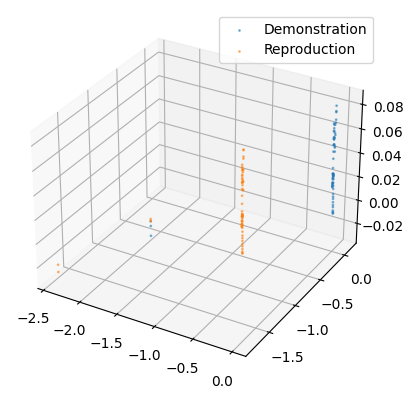

In [3]:
dataset = CALVINDynSysDataset(skill='open_drawer', state_type='ori', is_qaternion=False, train=True, goal_centered=True, demos_dir='data/')
dataset.plot_random()

### Parameters

In [4]:
dataset.X[0].shape

torch.Size([62, 4])

In [5]:
nb_data = dataset.X[0].shape[0]
nb_data_sup = 62
nb_samples = 10
dt = 0.06
sampling_dt = 0.03
input_dim = 3
output_dim = 3
in_idx = [0, 1, 2]
out_idx = [3, 4, 5]
nb_states = 3

In [6]:
# Create velocity data
# demos_dx = np.array([(demos[i][2:, :] - demos[i][:-2, :])/dt for i in range(nb_samples)])
# demos = [demos[i][1:-1, :] for i in range(nb_samples)]

# Stack position and velocity data
demos_xdx = [np.hstack([dataset.X[i], dataset.dX[i]]) for i in range(nb_samples)]

# Stack demos
demos_np = demos_xdx[0]
for i in range(1, nb_samples):
    demos_np = np.vstack([demos_np, demos_xdx[i]])

In [7]:
demos_np.shape

(620, 8)

In [35]:
X = demos_np[:, 1:input_dim+1]
Y = demos_np[:, input_dim:]

# X = 2 * (X - np.min(X, axis=0))/ (np.max(X, axis=0) - np.min(X, axis=0)) 
X = X / np.linalg.norm(X, axis=1)[:, None]


# Y = 2 * (Y - np.min(Y, axis=0))/ (np.max(Y, axis=0) - np.min(Y, axis=0))
# Y = Y / np.linalg.norm(Y, axis=1)[:, None]

In [43]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                  X[p * nb_data:(p + 1) * nb_data, 1],
                  X[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0., 0., 0.),
                  scale_factor=0.02)
mlab.view(30, 120)
mlab.show()

In [16]:
# mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
# fig = mlab.gcf()
# mlab.clf()
# # plot_sphere(figure=fig)
# # Plot data on the sphere
# for p in range(nb_samples):
#     if Y.shape[-1] == 2:
#         mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
#                       Y[p * nb_data:(p + 1) * nb_data, 1],
#                       np.ones(Y[p * nb_data:(p + 1) * nb_data, 1].shape),
#                       color=(0., 0., 0.),
#                       scale_factor=0.03)
#     else:
#         mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
#                       Y[p * nb_data:(p + 1) * nb_data, 1],
#                       Y[p * nb_data:(p + 1) * nb_data, 2],
#                       color=(0., 0., 0.),
#                       scale_factor=0.03)
# mlab.view(30, 120)
# mlab.show()

In [23]:
# Data in format compatible with pymanopt product of manifolds
data = np.empty((X.shape[0], 2), dtype=object)
for n in range(X.shape[0]):
    data[n] = [X[n], Y[n]]

In [38]:
data[0]

array([array([ 0.255342  ,  0.8166302 , -0.51760554], dtype=float32),
       array([-0.03808326,  0.10441087, -0.10971108, -0.09665052,  0.11743174],
             dtype=float32)                                                    ],
      dtype=object)

In [57]:
# Xt = dt * np.arange(nb_data + nb_data_sup)[:, None]

# Create the manifold
input_manifold = Sphere(input_dim)
output_manifold = Sphere(output_dim)
manifold = Product([input_manifold, output_manifold])

# Number of clusters
nb_clusters = 3

In [58]:
# K-means
km_means, km_assignments = manifold_k_means(manifold, data, nb_clusters=nb_clusters)

# GMM
initial_covariances = np.concatenate(nb_clusters * [np.eye(input_dim+output_dim)[None]], 0)
initial_priors = np.zeros(nb_clusters)
for k in range(nb_clusters):
    initial_priors[k] = np.sum(km_assignments == k) / len(km_assignments)
gmm_means, gmm_covariances, gmm_priors, gmm_assignments = manifold_gmm_em(manifold, data, nb_clusters,
                                                                          initial_means=km_means,
                                                                          initial_covariances=initial_covariances,
                                                                          initial_priors=initial_priors)
outdir = f'skill_ds/{dataset.state_type}/{dataset.skill}/gmm/'
os.makedirs(outdir, exist_ok=True)
filename = outdir + 'gmm_params.npz'
np.savez(filename, gmm_means=gmm_means, gmm_covariances=gmm_covariances, gmm_priors=gmm_priors)

Converged after 7 iterations: 2.012e+01


In [16]:
# Xt = sampling_dt * X[:62].reshape(-1, input_dim)
# Xt = dt * X[nb_data + nb_data_sup] 
Xt = X[:62].reshape(-1, input_dim)

In [67]:
Xt = X.reshape(-1, input_dim)

In [17]:
Xt.shape

(62, 3)

In [18]:
mu_gmr, sigma_gmr, H = manifold_gmr(Xt, manifold, gmm_means, gmm_covariances, gmm_priors)

## Input Space

In [73]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                  X[p * nb_data:(p + 1) * nb_data, 1],
                  X[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0., 0., 0.),
                  scale_factor=0.03)
# Plot Gaussians
for k in range(nb_clusters):
    mlab.points3d(gmm_means[k, 0][0],
                  gmm_means[k, 0][1],
                  gmm_means[k, 0][2],
                  color=(1, 0., 0.),
                  scale_factor=0.05)
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 0], gmm_covariances[k, :input_dim, :input_dim], color=(0.5, 0, 0.2))

mlab.view(30, 120)
mlab.show()

## Output Space

In [1]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                  Y[p * nb_data:(p + 1) * nb_data, 1],
                  Y[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0., 0., 0.),
                  scale_factor=0.03)
    
# Plot Gaussians
for k in range(nb_clusters):
    mlab.points3d(gmm_means[k, 1][0],
                  gmm_means[k, 1][1],
                  gmm_means[k, 1][2],
                  color=(1, 0., 0.),
                  scale_factor=0.05)
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 1], gmm_covariances[k, input_dim:, input_dim:], color=(0.5, 0, 0.2))

# Plot GMR trajectory
for n in range(Xt.shape[0]):
    # Plot mean and covariance
    plot_gaussian_mesh_on_tangent_plane(mu_gmr[n], sigma_gmr[n], color=(0.20, 0.54, 0.93))
    # Plot mean only
    mlab.points3d(mu_gmr[n, 0], mu_gmr[n, 1], mu_gmr[n, 2],
                  color=(0.20, 0.54, 0.93),
                  scale_factor=0.03)
mlab.view(30, 120)
mlab.show()

NameError: name 'mlab' is not defined

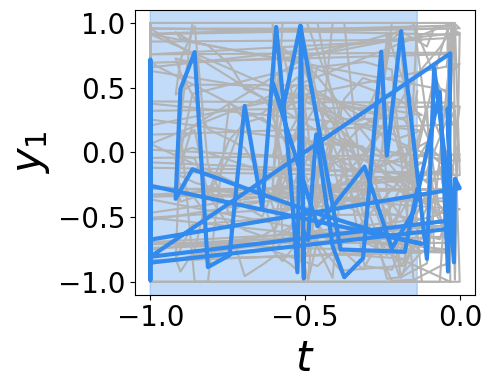

In [25]:
plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 0], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 0], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 0] - np.sqrt(sigma_gmr[:, 0, 0])
maxy = mu_gmr[:, 0] + np.sqrt(sigma_gmr[:, 0, 0])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_1$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure1.png', dpi=100)

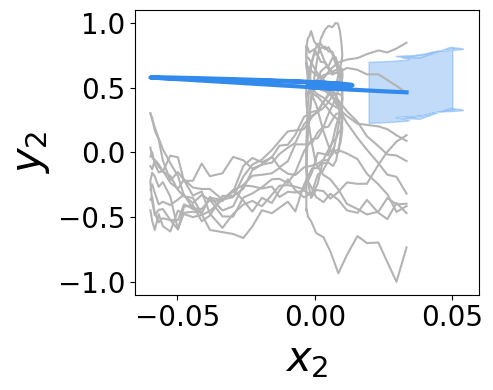

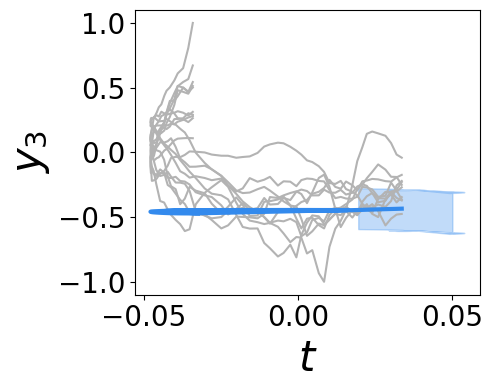

In [48]:
plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    if nb_samples == 5:
        nb_data = 190
    plt.plot(Xt[:nb_data, 1], Y[p * nb_data:(p + 1) * nb_data, 1], color=[.7, .7, .7])
plt.plot(Xt[:, 1], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 1] - np.sqrt(sigma_gmr[:, 1, 1])
maxy = mu_gmr[:, 1] + np.sqrt(sigma_gmr[:, 1, 1])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$x_2$', fontsize=30)
plt.ylabel('$y_2$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure2.png', dpi=100)
# plt.show()

plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    if nb_samples == 5:
        nb_data = 190
    plt.plot(Xt[:nb_data, 2], Y[p * nb_data:(p + 1) * nb_data, 2], color=[.7, .7, .7])
plt.plot(Xt[:, 2], mu_gmr[:, 2], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 2] - np.sqrt(sigma_gmr[:, 2, 2])
maxy = mu_gmr[:, 2] + np.sqrt(sigma_gmr[:, 2, 2])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_3$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure3.png', dpi=100)